In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

import utils.torchUtils as gnn

In [2]:
signal = ObjIter([Tree(fc.eightb.preselection.NMSSM_XYY_YToHH_8b_MX_1000_MY_450)])
qcd = ObjIter([Tree(fc.eightb.preselection.QCD_B_List)])

In [3]:
# signal = EventFilter('all eightb', nfound_presel=8).filter(signal)
# signal = CollectionFilter('jet', filter=lambda t:t.jet_signalId>-1).filter(signal)

topbtag = CollectionFilter('jet', filter=lambda t:ak.argsort(ak.argsort(-t.jet_btag,axis=-1),axis=-1)<8)

signal = signal.apply(topbtag)
qcd = qcd.apply(topbtag)

In [4]:
import awkward0 as ak0

# mlp_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/mlp_dijet/output"
rank_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output"
class_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_Y_pure/output"
# gnn_kin_path = "/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/graph_dijet_kin/output"

def load_class_output(path):
    output = ak0.load(path)
    # scores = ak.from_awkward0(output['scores'])
    scores = output['scores']
    # scores= scores.reshape(-1, 35)
    scores = ak.from_awkward0(scores)[:,:,1]
    scores = ak.from_regular(scores)
    # min_score, max_score = ak.min(scores, axis=-1), ak.max(scores, axis=-1)
    # return (scores - min_score)/(max_score - min_score)
    return scores

def load_rank_output(path):
    output = ak0.load(path)
    scores = output['scores']
    return ak.from_regular(scores.reshape(-1, 35))

def load_regex_output(regex, load):
    print(glob.glob(regex))
    path = glob.glob(regex)[0]
    return load(path)

In [5]:
import glob 

def load_signal_output(tree):
    mass = tree.sample
    scores = {
        'rank_score':{'path':rank_path,'score':[],'load':load_rank_output},
        # 'class_score':{'path':class_path,'score':[],'load':load_class_output}
    }
    for key, info in scores.items():
        info['score'] = load_regex_output(f'{info["path"]}/*{mass}*', info["load"])
    scores = { key:info['score'] for key,info in scores.items() }
    tree.extend(**scores)
signal.apply(load_signal_output)


['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/NMSSM_XYY_YToHH_8b_MX_1000_MY_450_accstudies.awkd']


[None]

In [6]:
def load_bkg_output(tree):
  scores = {
    'rank_score':{'path':rank_path,'score':[],'load':load_rank_output},
    # 'class_score':{'path':class_path,'score':[],'load':load_class_output}
  }
  for f in tree.filelist:
    for key, info in scores.items():
      info['score'].append( load_regex_output(f'{info["path"]}/{f.sample}*', info['load']) )
  scores = { key:ak.concatenate(info['score']) for key,info in scores.items() }
  tree.extend(**scores)
qcd.apply(load_bkg_output)


['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT100to200_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT200to300_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT300to500_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT500to700_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT700to1000_TuneCP5_13TeV-madgraph-pythia8.awkd']
['/uscms_data/d3/ekoenig/8BAnalysis/studies/weaver-benchmark/x_yy_4h_8b/models/rank_graph_Y_pure/output/QCD_bEnriched_HT1000to1500_TuneCP5_13TeV-madgraph-pythia8.aw

[None]

In [7]:
(signal+qcd).apply(eightb.build_all_ys)

[None, None]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


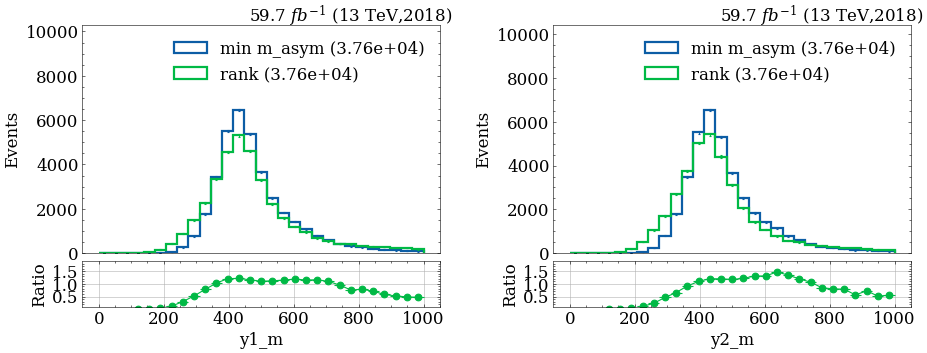

In [8]:
study.quick(
  signal[[0,0]], h_color=None, label=['min m_asym','rank'], legend=True,
  indicies=[
    lambda t: ak.argmin(t.ym_asym,axis=-1,keepdims=True), 
    # lambda t: ak.argmax(t.class_score,axis=-1, keepdims=True), 
    lambda t: ak.argmax(t.rank_score,axis=-1, keepdims=True)
  ],
  varlist=['y1_m','y2_m'], binlist=[np.linspace(0,1000,30)]*2,

  ratio=True,
)

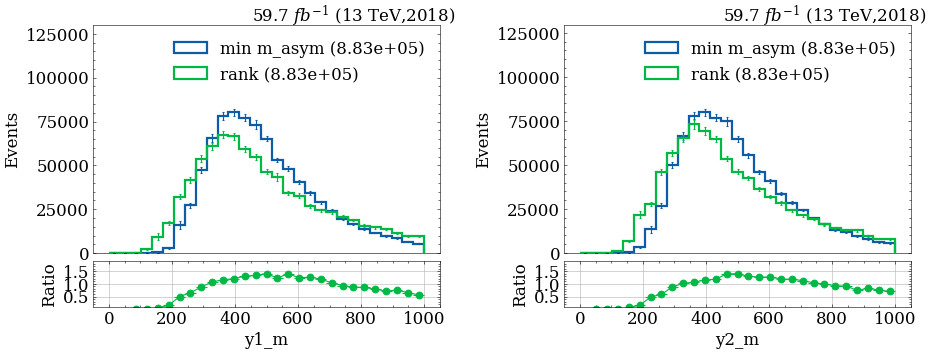

In [9]:
study.quick(
  qcd[[0,0]], h_color=None, label=['min m_asym','rank'], legend=True,
  indicies=[
    lambda t: ak.argmin(t.ym_asym,axis=-1,keepdims=True), 
    # lambda t: ak.argmax(t.class_score,axis=-1, keepdims=True), 
    lambda t: ak.argmax(t.rank_score,axis=-1, keepdims=True)
  ],
  varlist=['y1_m','y2_m'], binlist=[np.linspace(0,1000,30)]*2,
  ratio=True,
)

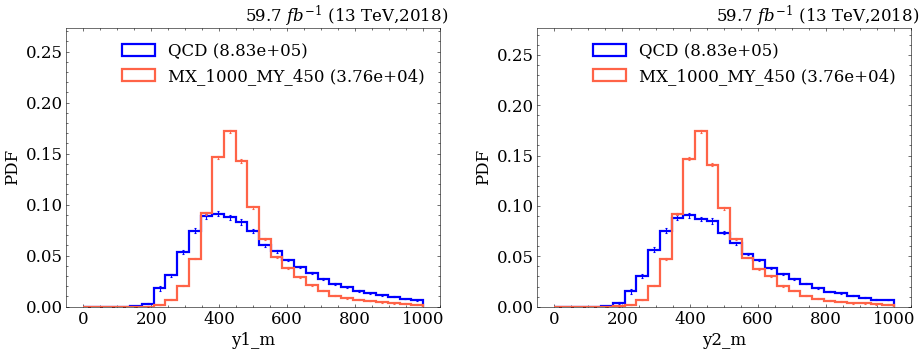

In [10]:
study.quick(
  qcd+signal, legend=True, density=True,
  indicies=lambda t: ak.argmin(t.ym_asym,axis=-1,keepdims=True), 
  varlist=['y1_m','y2_m'], binlist=[np.linspace(0,1000,30)]*2
)

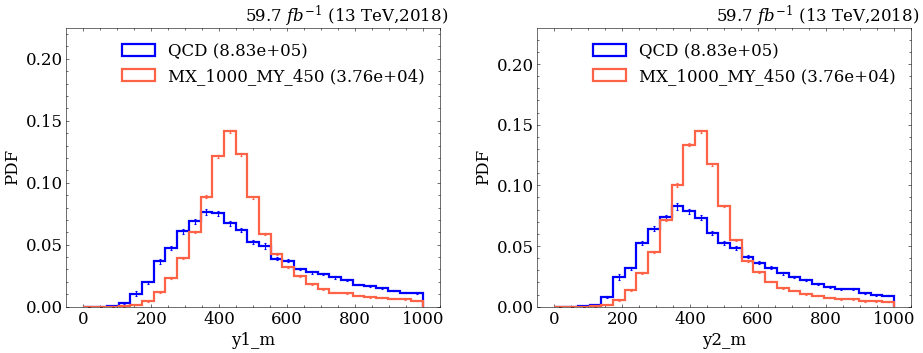

In [11]:
study.quick(
  qcd+signal, legend=True, density=True,
  indicies=lambda t: ak.argmax(t.rank_score,axis=-1, keepdims=True),
  varlist=['y1_m','y2_m'], binlist=[np.linspace(0,1000,30)]*2
)

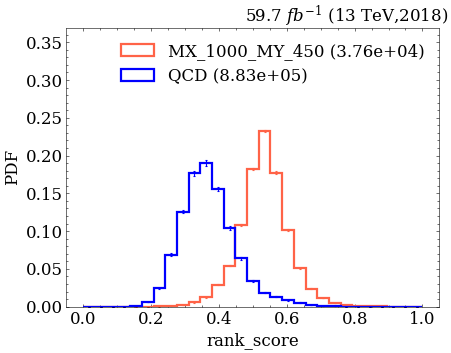

In [12]:
study.quick(
  signal+qcd, legend=True, density=True,
  indicies=lambda t: ak.argmax(t.rank_score,axis=-1, keepdims=True),
  varlist=['rank_score'], binlist=[(0,1,30)]*2
)

In [13]:
def build_best_bois(tree):
  btagavg = ak.mean(tree.jet_btag,axis=-1)
  maxscore = ak.max(tree.rank_score,axis=-1)
  ptavg = ak.mean(tree.jet_pt, axis=-1)/ak.max(tree.jet_pt,axis=-1)
  tree.extend(btagavg=btagavg, maxscore=maxscore, ptavg=ptavg)
(signal+qcd).apply(build_best_bois)

[None, None]

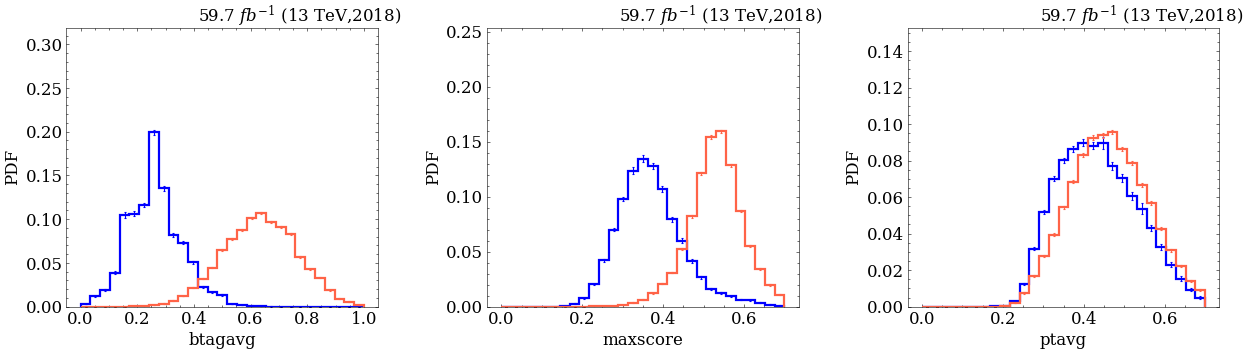

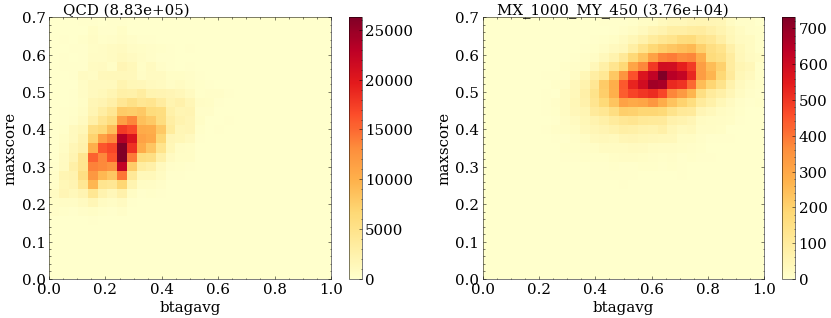

In [14]:
study.quick(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["btagavg","maxscore","ptavg"],
  binlist=[(0,1,30),(0,0.7,30),(0,0.7,30)],
  density=True,
  dim=(-1,3),
)

study.quick2d(
  qcd+signal, 
  # masks=lambda t:ak.max(t.quadh_score,axis=-1)>0.2,
  varlist=["btagavg","maxscore"],
  binlist=[(0,1,30),(0,0.7,30)],
)

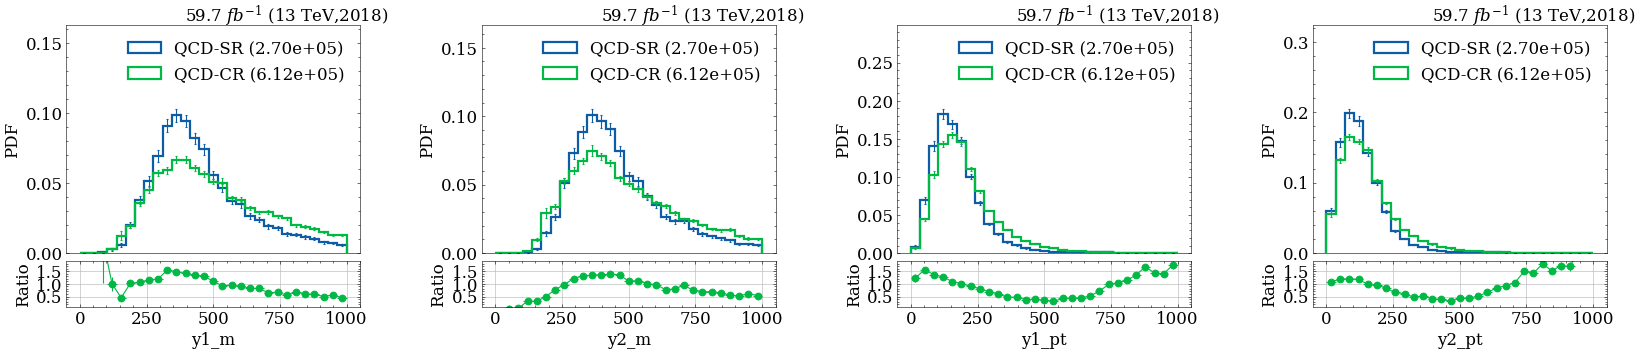

In [17]:
study.quick(
  qcd[[0,0]],h_color=None,label=['QCD-SR','QCD-CR'],  legend=True,
  indicies=lambda t:ak.argmax(t.rank_score,axis=-1, keepdims=True),
  masks=[lambda t:ak.max(t.rank_score,axis=-1)>0.4,lambda t:ak.max(t.rank_score,axis=-1)<0.4],
  varlist=[f'y{i+1}_{var}' for var in ('m','pt') for i in range(2) ],
  binlist=[(0,1000,30)]*4,
  density=True,
  ratio=True,
  dim=(-1,4),
)

In [18]:
tree=qcd[0]
tree_btag = tree.btagavg
tree_score = tree.maxscore
tree_scale = tree.scale

In [27]:
x = np.linspace(0.1,0.8,10)

def get_avg_btag(x_lo, x_hi):
  mask = (tree_score > x_lo) & (tree_score < x_hi)
  if (ak.sum(mask) == 0): return (0,0)
  return get_avg_std(tree_btag[mask], tree_scale[mask])

y = np.array(np.vectorize(get_avg_btag)(x[:-1], x[1:]))


{'c0': 0.20676298371170773, 'c1': 0.05337357748727894}


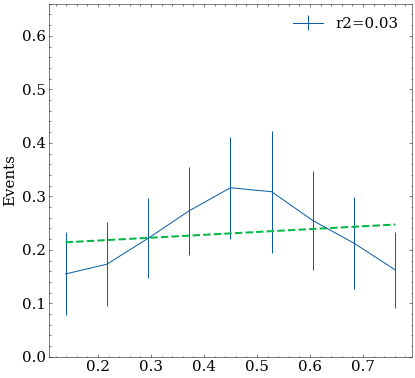

In [28]:
c = get_bin_centers(x)
graph = Graph(c, y[0], yerr=y[1], fit='linear', label_stat='r2={r2:0.2f}')
plot_graph(graph, legend=True)
print(graph.fit.params)